In [1]:
# Initialize Sentiment Analyzer

import nltk
import warnings
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

try:
    sia = SentimentIntensityAnalyzer()
except LookupError:
    nltk.download('vader_lexicon')
    sia = SentimentIntensityAnalyzer()

In [2]:
# Scraping Facebook posts from Business Times

from urllib.request import urlopen
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import time
import pprint

date_sentiments = {}

for i in range(1, 6):
    
    page = urlopen('https://www.businesstimes.com.sg/search/Facebook?page='+str(i)).read()
    soup = BeautifulSoup(page, features="html.parser")
    posts = soup.findAll("div", {"class": "media-body"})
    
    for post in posts:
        time.sleep(1)
        url = post.a['href']
        date = post.time.text
        try:
            link_page = urlopen(url).read()
            print(date, url)
        except:
            url = url[:-2]
            try:
                link_page = urlopen(url).read()
                print(date, url)
            except:
                pass
        link_soup = BeautifulSoup(link_page)
        sentences = link_soup.findAll("p")
        passage = ""
        for sentence in sentences:
            passage += sentence.text
        sentiment = sia.polarity_scores(passage)['compound']
        date_sentiments.setdefault(date, []).append(sentiment)

date_sentiment = {}

print('\nDate', '\t Sentiment rate \n')

for k, v in date_sentiments.items():
    date_sentiment[datetime.strptime(k, '%d %b %Y').date() + timedelta(days=1)] = round(sum(v) / float(len(v)), 3)
    print(k, '\t' + str(round(sum(v) / float(len(v)), 3)))

earliest_date = min(date_sentiment.keys())

26 Jul 2019 https://www.businesstimes.com.sg/technology/australian-watchdog-calls-for-controls-on-facebook-google
25 Jul 2019 https://www.businesstimes.com.sg/technology/facebook-firm-in-its-quest-to-launch-libra-cryptocurrency
25 Jul 2019 https://www.businesstimes.com.sg/technology/legal-penalties-dent-facebook-profit-revenue-user-base-grows
24 Jul 2019 https://www.businesstimes.com.sg/companies-markets/facebook-to-pay-record-us5-billion-to-settle-ftc-privacy-claims
24 Jul 2019 https://www.businesstimes.com.sg/technology/facebook-to-create-privacy-panel-pay-us5b-to-us-to-settle-allegations
24 Jul 2019 https://www.businesstimes.com.sg/technology/facebook-to-fix-kids-app-flaw-allowing-chats-with-strangers
18 Jul 2019 https://www.businesstimes.com.sg/banking-finance/us-congress-pushes-for-answers-on-facebooks-crypto-foray
18 Jul 2019 https://www.businesstimes.com.sg/technology/facebook-should-not-be-trusted-with-crazy-cryptocurrency-plan-say-us-senators
18 Jul 2019 https://www.businessti

2019-07-10, Close, 202.73
0.246
2019-07-11, Close, 201.23
-0.428
2019-07-12, Close, 204.87
0.684
2019-07-12, BUY CREATE, 204.87
2019-07-15, BUY EXECUTED, Price: 204.25, Cost: 2042.50, Comm 2.04
2019-07-15, Close, 203.91
0.684
2019-07-16, Close, 203.84
-0.548
2019-07-17, Close, 201.80
0.986
2019-07-18, Close, 200.78
0.962
2019-07-19, Close, 198.36
0.883
2019-07-22, Close, 202.32
0.883
2019-07-23, Close, 202.36
0.883
2019-07-24, Close, 204.66
0.883
2019-07-24, (MA Period 15) Ending Value 100002.06
Final Portfolio Value: 100002.06


<IPython.core.display.Javascript object>


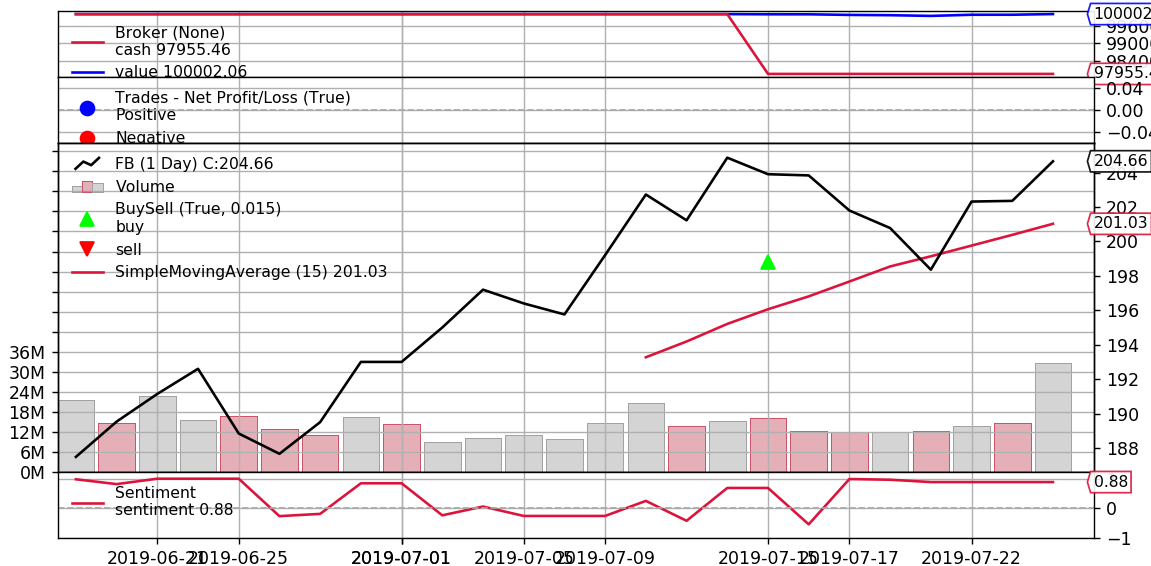

In [3]:
# Algorithm for an awesome show

from __future__ import (absolute_import, division, print_function, unicode_literals)
import backtrader as bt
import backtrader.indicators as btind
import datetime
import os.path
import sys

class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotymargin=0.15,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])
    
    def next(self):
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        self.lines.sentiment[0] = self.sentiment


class SentimentStrat(bt.Strategy):
    params = (
        ('period', 15),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
            self.bar_executed = len(self)     
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    ### Main Strat ###
    def next(self):
        # log closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        
        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return
        print(self.sentiment)
        # If not in the market and previous sentiment not none
        if not self.position and prev_sentiment:
            # buy if current close more than sma AND sentiment increased by >= 0.5
            if self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment >= 0.5:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
                
        # Already in the market and previous sentiment not none
        elif prev_sentiment:
            # sell if current close less than sma AND sentiment decreased by >= 0.5
            if self.dataclose[0] < self.sma[0] and self.sentiment - prev_sentiment <= -0.5:
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)
        

if __name__ == '__main__':
    cerebro = bt.Cerebro()
    
    # Strategy
    cerebro.addstrategy(SentimentStrat)

    # Data Feed
    data = bt.feeds.YahooFinanceData(
        dataname = "FB",
        fromdate = earliest_date,
        todate = datetime.datetime(2019,7,25),
        reverse = False
    )
    
    cerebro.adddata(data)

    cerebro.broker.setcash(100000.0)
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)
    cerebro.broker.setcommission(commission=0.001)
#     print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    cerebro.plot()